In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from scipy import stats

In [0]:
def model(theta,input_batch):
    sm = torch.nn.Softmax(dim=0)
    return torch.gather(sm(theta), 0, input_batch)

def curr_loss(output):
    return torch.mean(-1*torch.log2(output))

In [0]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.l1 = torch.nn.Linear(200, 200)
        self.l2 = torch.nn.Linear(200, 200)
        self.l3 = torch.nn.Linear(200, 200)

    def forward(self,input):
        second_model = torch.nn.Sequential(
            self.l1,
            torch.nn.ReLU(),
            self.l2,
            torch.nn.ReLU(),
            self.l3)

        return second_model(input)

In [0]:
torch.manual_seed(0)

x = np.load('distribution.npy')
samples = np.random.choice(x.flatten().shape[0], size=(100000,), p=x.flatten())
indices = np.unravel_index(samples, shape=x.shape)
index_pairs = np.stack(indices, axis=-1)

batch_size = 512

train_set, validation_set, test_set = torch.utils.data.random_split(index_pairs,
                                                                  (int(len(index_pairs) * .6),
                                                                    int(len(index_pairs) * .2),
                                                                    int(len(index_pairs) * .2)))

training_data = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

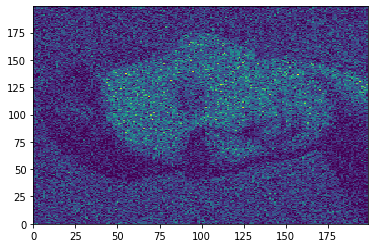

In [12]:
plt.hist2d(index_pairs[:,0], index_pairs[:,1], bins=200, range=np.array([[0,199], [0,199]]))
plt.show()

In [17]:
mlp = MLP()

theta = torch.autograd.Variable(torch.zeros(200,), requires_grad=True)
optimizer = torch.optim.Adam(list([theta]) + list(mlp.parameters()), lr=0.001)
epochs = 35

training_loss = []

for i in range(epochs):
    j = 0
    for batch in training_data:
      optimizer.zero_grad()

      model_one_batch = batch[:, 0]
      model_two_labels = batch[:, 1]

      model_one_loss = curr_loss(model(theta, model_one_batch))

      one_hot = F.one_hot(model_one_batch, num_classes=200).float()
      logits = mlp.forward(one_hot)

      model_two_loss = F.cross_entropy(logits, model_two_labels) * np.log2(np.e)
      loss = (model_one_loss + model_two_loss)

      if j == len(training_data)-1 or (i == 0 and j == 0):
        print("Epoch:",i, "  Batch:",j,"  Loss:",loss.item(),"bits/dim")

      loss.backward()
      optimizer.step()
      training_loss.append(loss)
      j += 1


Epoch: 0   Batch: 0   Loss: 15.285614013671875 bits/dim
Epoch: 0   Batch: 117   Loss: 15.19852352142334 bits/dim
Epoch: 1   Batch: 117   Loss: 15.233354568481445 bits/dim
Epoch: 2   Batch: 117   Loss: 15.17121410369873 bits/dim
Epoch: 3   Batch: 117   Loss: 15.148271560668945 bits/dim
Epoch: 4   Batch: 117   Loss: 15.056640625 bits/dim
Epoch: 5   Batch: 117   Loss: 15.195054054260254 bits/dim
Epoch: 6   Batch: 117   Loss: 15.157167434692383 bits/dim
Epoch: 7   Batch: 117   Loss: 15.096220016479492 bits/dim
Epoch: 8   Batch: 117   Loss: 15.079861640930176 bits/dim
Epoch: 9   Batch: 117   Loss: 14.951700210571289 bits/dim
Epoch: 10   Batch: 117   Loss: 14.984964370727539 bits/dim
Epoch: 11   Batch: 117   Loss: 15.05025863647461 bits/dim
Epoch: 12   Batch: 117   Loss: 14.949308395385742 bits/dim
Epoch: 13   Batch: 117   Loss: 15.080633163452148 bits/dim
Epoch: 14   Batch: 117   Loss: 14.983561515808105 bits/dim
Epoch: 15   Batch: 117   Loss: 14.893461227416992 bits/dim
Epoch: 16   Batch: 

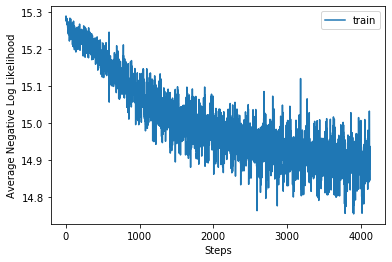

In [18]:
plt.xlabel('Steps')
plt.ylabel('Average Negative Log Likelihood')
plt.plot(training_loss, label='train')
plt.legend()
plt.show()

In [0]:
sample_x = np.arange(0, 200, 1)
probabilities = model(theta, torch.from_numpy(sample_x))

prob_dist = torch.distributions.Categorical(probabilities)
sample = prob_dist.sample([100000])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  after removing the cwd from sys.path.


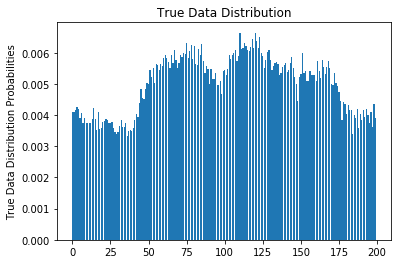

In [25]:
plt.title('True Data Distribution')
plt.ylabel('True Data Distribution Probabilities')

freq = stats.itemfreq(index_pairs[:,0])
x = freq[:, 0]
y = freq[:, 1] / len(index_pairs[:,0])

plt.bar(x, y)
plt.show()

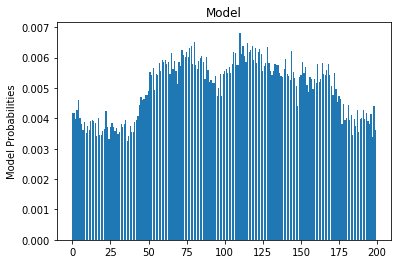

In [26]:
plt.title("Model")
plt.ylabel('Model Probabilities')

plt.bar(sample_x, probabilities.detach().numpy())
plt.show()

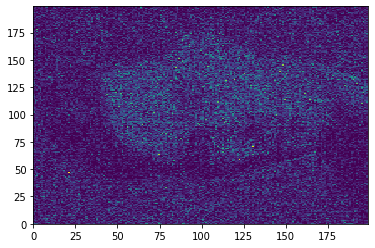

In [27]:
mlp.eval()

dist = mlp.forward(F.one_hot(sample, num_classes=200).float())

sm = torch.nn.Softmax(dim=1)
dist = sm(dist)
pro = torch.distributions.Categorical(dist)
samps = pro.sample([1])

plt.hist2d(sample.numpy(), samps[0].numpy(), bins=200, range=np.array([[0, 199], [0, 199]]))

plt.show()